# Testing Cross Validation Strategies
Many data science projects aim for generalizable models---models that perform well on new data---such as scoring new credit card applicants or predicting who will win a football game. A common approach to modeling is to split your data, using different splits for different tasks. If you have a lot of data, you might split it into three subsets:

* **Train set** for fitting candidate models
* **Validation set** for selecting a model ('which of the fitted candidate models is best?')
* **Test set** for assessing the selected model ('how accurate is the best model?')

A more common approach is to use cross validation. Cross validation eliminates the need for a separate validation set by using the train set for training and validation:

* split the train set into k folds
* fit the model(s) on all but the kth fold and test on the kth fold
* fit the model(s) on all but the (k-1)th fold and test on the (k-1)th fold
* ...
* fit the model(s) on all but the 1st fold and test on the 1st fold

In both cases, we retrain the selected model on all the training and validation sets before testing.

How you choose to split the data for training, validating, and testing is critical. If your train set contains information about the validation or test sets that would not be available in the real world, your model selection and assessment may be wrong. This is a type of *leakage*, and it can lead to wrong model choice and overly optimistic error estimates. 

We typically learn to do "standard cross validation," where the splits are made randomly. That works well for independent and identically distributed data, but many (most?) real-world problems have dynamic data-generating processes that make standard CV less than ideal. You'll typically do better splitting the data in a way that mimics how the model will be used. For example, if you're trying to build a good forecasting model, you should probably split the data by time. That way you'll choose the model that would have forecasted best, rather than the model that best predicted some combination of the future and past.   

This notebook presents a couple simple prediction problems with publicly available data covering a long time range. It compares several model selection and assessment strategies:

* *None*: No validation set. Choose the model with the lowest training error for testing.
* *Standard*: Choose the model with lowest error in standard CV.
* *Standard with holdout*: Set aside the last x time as a holdout set. Use standard CV on the rest of the data to choose a model. (This is common in many of the best social science prediction papers.)
* *Temporal with holdout*: Set aside the last x time as a holdout set. Use temporal CV on the rest of the data to choose a model.  
* *Temporal*: Choose the model with lowest error in temporal CV.

We will compare the performance of each on the following:

* *Model selection*: Would the strategy have chosen the best model?
* *Model assessment*: Would the strategy provided an accurate estimate of model error?

The first example uses regression to predict annual US GDP, and the second uses classification to predict recidivism.

In [1]:
import csv
from itertools import product
import multiprocessing as mp
import pickle
import csv

import numpy as np
import pandas as pd
from plotnine import *
from sklearn import linear_model, ensemble, metrics
import random
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Regression Example: Predicting US Gross Domestic Product
Let's say it's December 31, 2017, and we want to predict next year's nominal US Gross Domestic Product (GDP). So we'll try to do two things:

1. Choose the model that is most likely to give us an accurate estimate for 2018.
2. Estimate how accurate we should expect that model to be in 2018, so we have a sense for how much we can trust the results.

We don't know what will happen in 2018, but we do know what happened in 2017, 2016, 2015, and so on. We can simulate what would have happened if we tried fitting, validating, and testing models in the past, the same way we want to do now.  
<!---If it's reasonable to assume [stationarity](https://en.wikipedia.org/wiki/Stationary_process) and a thin-tailed distribution (which GDP may not be, but this is an example), this historical approach can work quite well.--->

Here's how we would have done if we were predicting GDP for 2017:

1. Choose the model that performed best through 2016.
2. Fit the best model on all data available through 2016, predict for 2017, and compare our prediction to the actual GDP.

We can do the same thing for the year before:

1. Choose the model that performed best through 2015.
2. Fit the best model on all data available through 2016, predict for 2016, and compare our prediction to the actual GDP.

And repeat again and again, each time a year earlier. We'll try all our model-selection strategies in each loop. 

We collected data from six sources:

* [GDP](https://bea.gov/iTable/iTable.cfm?ReqID=19&step=4&isuri=1&1921=flatfiles) from the Bureau of Economic Analysis (code T10105-A)
* [Historical oil prices](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=rwtc&f=a) from US Energy Information Administration (Cushing, OK WTI Spot Price, starts in 1986)
* Presidential Election Year
* Republican Administration
* [US population](http://www.multpl.com/united-states-population/table)
* [S&P 500 Price-Earnings Ratio](http://www.multpl.com/table)
* A column from a random number generator

Let's start by plotting GDP over time.

In [2]:
GDP_df = pd.read_csv('GDP.csv')

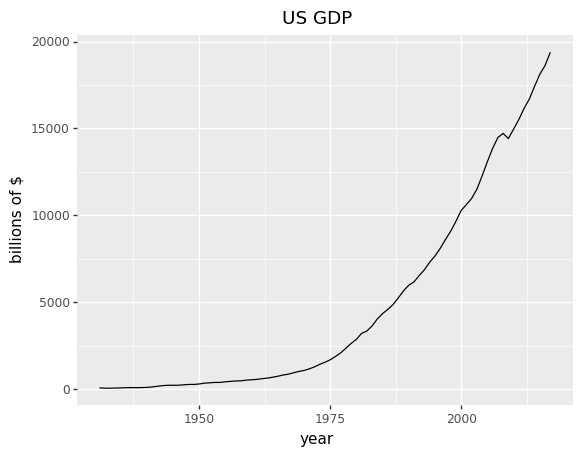

<ggplot: (293450013)>

In [121]:
(ggplot(GDP_df, aes(x='year', y='GDP')) +
    geom_line() +
    ggtitle('US GDP') +
    xlab('year') +
    ylab('billions of $')
)

<!--Look at the dip after 2000. If you randomly assign rows to the train, validate, and test sets, your model might fit post-Great Recession data and validate/test on Great Recession data. Then the model effectively knows GDP drops before it happens, resulting in error rates that are too small for the validation and test sets.  

<!--**To avoid problems like this, you should design your train/validation/test splits to mimic how you will use your model.**--> 
GDP is our target variable. We have created several features. If we want to predict what GDP will be next year, we can't use next year's features. The features need to precede the target, i.e. the features need to be from this year or the past:

* The year
* Previous year's GDP
* GDP from two years before
* Previous year's oil price. The data only go back to 1986. I zero imputed the rest.
* Presidential Election Year (takes a 1 if an election year and a 0 otherwise)
* Republican Administration (takes a 1 if the president is a Republican and a 0 otherwise)
* Previous year's population
* Previous year's S&P 500 Price-Earnings Ratio
* A random integer between 0 and 1000. It should only predict the outcome by chance.

Here's what the data look like:

In [3]:
GDP_df.head(n=15)

,year,GDP,GDP lag 1,GDP lag 2,Election Year,Republican Administration,oil prices lag 1,Population lag 1,S&P 500 PE Ratio lag 1,Random
0,1931,77.406,92.167,104.560,0,1,0.0,123.08,13.92,481
1,1932,59.532,77.406,92.167,1,1,0.0,124.04,17.00,65
2,1933,57.165,59.532,77.406,0,0,0.0,124.84,14.07,737
3,1934,66.812,57.165,59.532,0,0,0.0,125.58,17.29,682
4,1935,74.259,66.812,57.165,0,0,0.0,126.37,23.95,51
5,1936,84.854,74.259,66.812,1,0,0.0,127.25,16.25,522
6,1937,93.029,84.854,74.259,0,0,0.0,128.05,17.87,441
7,1938,87.387,93.029,84.854,0,0,0.0,128.82,16.75,694
8,1939,93.473,87.387,93.029,0,0,0.0,129.82,10.47,875
9,1940,102.946,93.473,87.387,1,0,0.0,130.88,18.94,778


How many observations do the models have for fitting?

In [4]:
GDP_df.shape[0]

87

Let's define the features and target: 

In [5]:
X_cols = ['year', 'GDP lag 1', 'GDP lag 2', 'Election Year', 'Republican Administration',
          'oil prices lag 1', 'Population lag 1', 'S&P 500 PE Ratio lag 1', 'Random']
X_subset = ['GDP lag 1']
y_col = 'GDP'

In practice, we can try [hundreds](https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py) or even thousands of model types. To keep things simple, we'll try four here:

* Ordinary least squares (with an intercept)
* Ridge regression (OLS with an L2 penalty on the coefficients. For this exercise, I decided to try a quite high penalty of 5).
* Lasso regression (OLS with an L1 penalty on the coefficients. Again, using a penalty of 5)
* An OLS Model that will only use the GDPs of the prior years, log transformed.

In [6]:
clfs = {
    'ols': linear_model.LinearRegression(),
    'ridge': linear_model.Ridge(alpha=5),
    'lasso': linear_model.Lasso(alpha=5),
    'ols_logGDP': linear_model.LinearRegression(),
    
}

cols_to_use = {
    'ols': X_cols,
    'ridge': X_cols,
    'lasso': X_cols,
    'ols_logGDP': X_subset   
}

We need to define the range of years for the test sets. Although the data begin in the early 1930s, our test sets begin in the 1940s. Our models use OLS, which requires at least as many rows of data as columns to fit the model. We have 9 predictors (see `X_cols`) plus an intercept, so we need at least 10 rows to fit the model. We get enough rows using 1931 through 1940.

We also need an extra row (year) for validation. Using temporal CV, that means our first validation year is 1941, so the first possible test year is 1942. (The results will probably be terrible, given how little training data we had and our model selection is based on a single observation.) In standard CV, we can validate on all of the years from the beginning by varying our training set. See below for a more complete example.

In [7]:
test_begin_year = 1942
test_end_year = 2017  
test_years = range(test_begin_year, test_end_year+1)

A couple of validation-set rules:

1. Validation set years should precede the test set years
2. For temporal cross validation, validation set years should follow train set years. 

Given these, or validation years are below.

In [8]:
temporal_validation_years = range(test_begin_year-1, test_end_year)
standard_validation_years = range(1931, test_end_year)

To visualize the difference between the the two CV techniques, consider an example. Assume it's 1942 and we want to predict GDP for 1943.

#### Example comparison:   
Standard CV can use 1931 - 1942 for validation years because of number of rows needed for linear regression.
* Standard CV produces the following validation and train sets
    * Validation: 1931, Training: 1932 - 1942
    * Validation: 1932, Training: 1931 & 1933 - 1942
    * Validation: 1933, Training: 1931 - 1932 & 1934 - 1942
    * Validation: 1934, Training: 1931 - 1933 & 1935 - 1942
    * Validation: 1935, Training: 1931 - 1934 & 1936 - 1942
    * Validation: 1936, Training: 1931 - 1935 & 1937 - 1942
    * Validation: 1937, Training: 1931 - 1936 & 1938 - 1942
    * Validation: 1938, Training: 1931 - 1937 & 1939 - 1942
    * Validation: 1939, Training: 1931 - 1938 & 1940 - 1942
    * Validation: 1940, Training: 1931 - 1939 & 1941 - 1942
    * Validation: 1941, Training: 1931 - 1940 & 1942
    * Validation: 1942, Training: 1931 - 1941
         
         
Temporal CV can use 1941 - 1942 for validation years.
* Temporal CV produces the following validation and train sets
    * Validation: 1941, Training: 1931 - 1940
    * Validation: 1942, Training: 1931 - 1941
    
Note that the validation errors on each fold will converge toward the later years of the training set, as the training and validation data become more similar. Our leave-one-out CV strategy and temporal CV will give the same results for the 1942 validation fold because the training (1931-1941) and validation (1942) data are the same. 

You'll almost always want to choose a validation and testing strategy that most closely mimics how your model will be used. If you don't, you'll choose a model that performs well for a different problem than the one you're trying to solve. In this example, where you want to predict GDP for 1951, you should choose temporal cross validation because you don't have data from after 1950 (in our hypothetical). Training the model on future data and testing on the past is cheating because the future contains information about the past. As a result, standard cross validation will theoretically tend to give predicted errors that are too small.  

## Standard Cross Validation

In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def standard_etl_fit_evaluate(df, test_year, validation_year, model):
    
    if validation_year < test_year:
        
        try:
            cv_start = 1931
            cv_end = test_year - 1
            X_columns = cols_to_use[model]
            
            # prep validation data
            df_validation = df[df.year == validation_year]
            y_validation = df_validation[y_col]
            
            if model == 'ols_logGDP':
                X_validation = np.log(df_validation[X_columns])
            else:
                X_validation = df_validation[X_columns]

            # prep training data
            df_standard_train = df[(df.year != validation_year) & (df.year < test_year)]
            
            if model == 'ols_logGDP':
                y_standard_train = np.log(df_standard_train[y_col])
                X_standard_train = np.log(df_standard_train[X_columns])
            else:
                y_standard_train = df_standard_train[y_col]
                X_standard_train = df_standard_train[X_columns]

            # fit the models
            clf = clfs[model]
            clf.fit(X_standard_train, y_standard_train)
            
            train_predictions = clf.predict(X_standard_train)
            validation_predictions = clf.predict(X_validation)
            
            if model == 'ols_logGDP':
                train_predictions = np.exp(train_predictions)
                validation_predictions = np.exp(validation_predictions)
                y_standard_train = np.exp(y_standard_train)
            
            train_error = mean_absolute_percentage_error(y_standard_train, train_predictions)
            validation_error = mean_absolute_percentage_error(y_validation, validation_predictions)

            # return the results
            return(cv_start, cv_end, validation_year, model, train_error, validation_error)
        
        except:
            pass

The cross validation requires training the models many times over. This can either be done sequentially or with parallelization. Both are demonstrated below and produce the same results. You can change with method is used by changing the boolean `parallel`.

In [10]:
warnings.filterwarnings(action="ignore", module="sklearn", message="^Objective")

In [11]:
parallel = True

if parallel:
    pool = mp.Pool()
    standard_cv_results = pool.starmap(standard_etl_fit_evaluate, product([GDP_df], test_years, standard_validation_years, clfs))
    pool.close()
    
    standard_cv_results_df = pd.DataFrame([x for x in standard_cv_results if x is not None],
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])
    
else:
    standard_cv_results = []
    for test_yr in test_years:
        for validation_yr in [year for year in standard_validation_years if year < test_yr]:
            for model in clfs:
                results = standard_etl_fit_evaluate(GDP_df, test_yr, validation_yr, model)
                standard_cv_results.append(results)
                
    standard_cv_results_df = pd.DataFrame(standard_cv_results,
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])
    

In [12]:
standard_cv_results_df.head()

,cv_start,cv_end,validation_year,model,train_error,validation_error
0,1931,1941,1931,ols,1.089600,26.115844
1,1931,1941,1931,ridge,2.940687,28.839504
2,1931,1941,1931,lasso,4.698921,16.713063
3,1931,1941,1931,ols_logGDP,10.628907,26.768612
4,1931,1941,1932,ols,1.089600,33.956914


With these results from the cross validation, we can then simulate our process of choosing which model we will use for each of the testing years. To do so, for each fold group (characterized by having the same final cv year) and model type, we average the cv errors from all of the validation years. Then we select the model with the lowest average cv error for the prior years to be our chosen model for that test year. Finally, we compare the performace of the test year's predicted value for GDP with its actual value to get our test error for that year.

In [13]:
# Grouping by the test year and the model type, what is the average cv_error?
grouped_standard_cv_results = standard_cv_results_df.groupby(['cv_end', 'model'])['validation_error'].mean().to_frame().reset_index()
grouped_standard_cv_results.rename(columns = {"validation_error": "mean_validation_error"}, inplace=True)

grouped_standard_cv_results.head(n=15)

,cv_end,model,mean_validation_error
0,1941,lasso,12.366571
1,1941,ols,28.262965
2,1941,ols_logGDP,15.220245
3,1941,ridge,12.510307
4,1942,lasso,11.358625
5,1942,ols,17.806287
6,1942,ols_logGDP,14.824483
7,1942,ridge,11.074313
8,1943,lasso,9.531622
9,1943,ols,10.972876


In [14]:
# Finding the models with the lowest average cv_error for each year
standard_cv_best_models = grouped_standard_cv_results.loc[grouped_standard_cv_results.groupby(['cv_end'])\
                                                         ['mean_validation_error'].idxmin()]

In [15]:
standard_cv_best_models.head(n=10)

,cv_end,model,mean_validation_error
0,1941,lasso,12.366571
7,1942,ridge,11.074313
11,1943,ridge,9.344677
15,1944,ridge,7.890208
19,1945,ridge,7.149755
23,1946,ridge,6.886750
25,1947,ols,7.721584
28,1948,lasso,7.117234
32,1949,lasso,7.677417
36,1950,lasso,6.819796


Now, to estimate the test error of each of our best models, we need to find the error of that model when it is trained on all the years prior to the test year and evaluated on the test year. Eg: the test error for OLS in 1943 is the error produced when OLS is trained on data from 1931 to 1942 and tested on 1943. 

 Recall that this is exactly one of the K folds performed in the original running of the models stored in `standard_cv_results_df`. In particular, it is when `cv_end` = `validation_year` = 1943.  So instead of retraining the model, we can simply retrieve the error calculated before. Except the final test year, which must be calculated.

In [16]:
standard_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
standard_cv_best_models["test_year"] = standard_cv_best_models["test_year"] + 1 # To go from cv end to test year

test_errors = []
for index, row in standard_cv_best_models.iterrows():
    test_yr = row["test_year"]
    model = row["model"]
    
    if test_yr != test_end_year:
        test_error = standard_cv_results_df[(standard_cv_results_df.cv_end == test_yr) \
                                          & (standard_cv_results_df.validation_year == test_yr)
                                          & (standard_cv_results_df.model == model)].iloc[0]["validation_error"]
    else:
        results = standard_etl_fit_evaluate(GDP_df, test_yr, test_yr - 1, model)
        test_error = results[5]
        
    test_errors.append(test_error)

standard_cv_best_models["test_error"] = test_errors
standard_cv_best_models["type"] = "standard"

In [17]:
standard_cv_best_models.head(n=15)

,test_year,model,mean_validation_error,test_error,type
0,1942,lasso,12.366571,16.441791,standard
7,1943,ridge,11.074313,1.744894,standard
11,1944,ridge,9.344677,0.018746,standard
15,1945,ridge,7.890208,3.364495,standard
19,1946,ridge,7.149755,6.249522,standard
23,1947,ridge,6.886750,13.554374,standard
25,1948,ols,7.721584,18.948446,standard
28,1949,lasso,7.117234,9.831971,standard
32,1950,lasso,7.677417,6.955595,standard
36,1951,lasso,6.819796,4.038443,standard


## Temporal Cross Validation

Temporal CV approaches the problem slightly differently. It uses the same set of validation years, but only trains on the years before the validation year, not the years after. In this way, it eliminates data leakage that can cause overfitting in models trained with Standard CV.
    
Note that, with temporal CV, each test year starts with the same validation and training sets. Therefore we do not have to retrain all of the models for every test year, so temporal CV is also much more efficient for our project. We can simply train all 4 models on each possible training set (1931 - 1939, 1931 - 1940, 1931 - 1941, ...) and store the results. Then, for a given test year, for each model, we simply average all the validation errors from all the years prior or a rolling window of years prior. In practice we often use a rolling window because if the underlying distribution of the data changes over time, we would like our cv strategy to predict errors that reflect these changes. Standard CV is far less efficient because validation requires unique train and validation sets. We cannot reuse results from another run.

In [22]:
def temporal_etl_fit_evaluate(df, year, model):
    
    cv_start = 1931
    cv_end = year
    validation_year = year # The first line of difference from standard CV
    X_columns = cols_to_use[model]
    
    # prep validation data
    df_validation = df[df.year == validation_year]
    y_validation = df_validation[y_col]

    if model == 'ols_logGDP':
        X_validation = np.log(df_validation[X_columns])
    else:
        X_validation = df_validation[X_columns]

    # prep training data
    df_standard_train = df[df.year < year] # The second line of difference from standard CV

    if model == 'ols_logGDP':
        y_standard_train = np.log(df_standard_train[y_col])
        X_standard_train = np.log(df_standard_train[X_columns])
    else:
        y_standard_train = df_standard_train[y_col]
        X_standard_train = df_standard_train[X_columns]

    # fit the models
    clf = clfs[model]
    clf.fit(X_standard_train, y_standard_train)

    train_predictions = clf.predict(X_standard_train)
    validation_predictions = clf.predict(X_validation)

    if model == 'ols_logGDP':
        train_predictions = np.exp(train_predictions)
        validation_predictions = np.exp(validation_predictions)
        y_standard_train = np.exp(y_standard_train)

    train_error = mean_absolute_percentage_error(y_standard_train, train_predictions)
    validation_error = mean_absolute_percentage_error(y_validation, validation_predictions)
    
    
    return(cv_start, cv_end, validation_year, model, train_error, validation_error)

Once again, we can use either a parallel or a sequential fitting of the models for all of the folds of the cross validation. 

In [23]:
parallel = True

if parallel:
    pool = mp.Pool()
    temporal_results = pool.starmap(temporal_etl_fit_evaluate, product([GDP_df], temporal_validation_years, clfs))
    
    pool.close()
    
else:
    temporal_results = []
    for validation_year in temporal_validation_years:
        for model in clfs:
            results = temporal_etl_fit_evaluate(GDP_df, validation_year, model)
            temporal_results.append(results)

    
temporal_results_df = pd.DataFrame(temporal_results,
                                  columns=['cv_start', 'cv_end', 'validation_year', 
                                           'model', 'train_error', 'validation_error'])

In [25]:
temporal_results_df.head(n=8)

,cv_start,cv_end,validation_year,model,train_error,validation_error
0,1931,1941,1941,ols,1.320016,42.607683
1,1931,1941,1941,ridge,3.543207,20.524031
2,1931,1941,1941,lasso,4.569951,28.724943
3,1931,1941,1941,ols_logGDP,11.617945,24.227677
4,1931,1942,1942,ols,2.492008,15.367902
5,1931,1942,1942,ridge,4.524786,12.179753
6,1931,1942,1942,lasso,5.167340,16.441791
7,1931,1942,1942,ols_logGDP,12.417258,20.523821


Recall that cv_start and cv_end mark are the inclusive bounds for the validation fold. Thus the training set is all the years in that fold except for the validation year. Temporal CV only ever validates on the last year of the set.

As described above, for each validation year we now can average the test errors from the years less inside our rolling window to get our test average cv error. This should match the form of `grouped_standard_cv_results`.

In [26]:
rolling_avg_num_years = 5

rows_list = []
for validation_yr in temporal_validation_years:
    for model in clfs:
        row_dict = {}
        row_dict["model"] = model
        row_dict["cv_end"] = validation_yr
        row_dict["mean_validation_error"] = temporal_results_df[\
                  (temporal_results_df.validation_year <= validation_yr) \
                & (temporal_results_df.validation_year >= validation_yr - rolling_avg_num_years) \
                & (temporal_results_df.model == model)]["validation_error"].mean()
        rows_list.append(row_dict)
        
grouped_temporal_cv_results = pd.DataFrame(rows_list)
grouped_temporal_cv_results.head(n=12)

,cv_end,mean_validation_error,model
0,1941,42.607683,ols
1,1941,20.524031,ridge
2,1941,28.724943,lasso
3,1941,24.227677,ols_logGDP
4,1942,28.987793,ols
5,1942,16.351892,ridge
6,1942,22.583367,lasso
7,1942,22.375749,ols_logGDP
8,1943,20.463862,ols
9,1943,11.482893,ridge


Just like the standard CV example, we can chose the best model for each test year from these mean validation errors and then retrieve the test errors from our run of all the validation sets stored in `temporal_results_df`. Like Standard CV, our final test year (1950) was never used as a validation set.

In [27]:
# Finding the models with the lowest average cv_error for each year
temporal_cv_best_models = grouped_temporal_cv_results.loc[grouped_temporal_cv_results.groupby(['cv_end'])\
                                                         ['mean_validation_error'].idxmin()]
temporal_cv_best_models.head(n=14)

,cv_end,mean_validation_error,model
1,1941,20.524031,ridge
5,1942,16.351892,ridge
9,1943,11.482893,ridge
13,1944,8.616856,ridge
17,1945,7.566384,ridge
21,1946,7.346907,ridge
24,1947,5.751661,ols
29,1948,4.226648,ridge
34,1949,5.704870,lasso
38,1950,6.266131,lasso


In [28]:
temporal_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
temporal_cv_best_models["test_year"] = temporal_cv_best_models["test_year"] + 1 # To go from cv end to test year

test_errors = []
for index, row in temporal_cv_best_models.iterrows():
    test_yr = row["test_year"]
    model = row["model"]
    
    if test_yr != test_end_year:
        test_error = temporal_results_df[(temporal_results_df.validation_year == test_yr)
                                       & (temporal_results_df.model == model)].iloc[0]["validation_error"]
    else:
        results = temporal_etl_fit_evaluate(GDP_df, test_yr, model)
        test_error = results[5]
        
    test_errors.append(test_error)

temporal_cv_best_models["test_error"] = test_errors

temporal_cv_best_models["type"] = "temporal"

In [29]:
temporal_cv_best_models.head()

,test_year,mean_validation_error,model,test_error,type
1,1942,20.524031,ridge,12.179753,temporal
5,1943,16.351892,ridge,1.744894,temporal
9,1944,11.482893,ridge,0.018746,temporal
13,1945,8.616856,ridge,3.364495,temporal
17,1946,7.566384,ridge,6.249522,temporal


Now we can compare the models selected and the testing errors generated by our temporal and our standard CV techniques.

### Results Comparison

In [30]:
temp_vs_std = pd.concat([standard_cv_best_models, temporal_cv_best_models]).sort_values(by="test_year")
temp_vs_std.head(n=20)

,mean_validation_error,model,test_error,test_year,type
0,12.366571,lasso,16.441791,1942,standard
1,20.524031,ridge,12.179753,1942,temporal
5,16.351892,ridge,1.744894,1943,temporal
7,11.074313,ridge,1.744894,1943,standard
11,9.344677,ridge,0.018746,1944,standard
9,11.482893,ridge,0.018746,1944,temporal
15,7.890208,ridge,3.364495,1945,standard
13,8.616856,ridge,3.364495,1945,temporal
17,7.566384,ridge,6.249522,1946,temporal
19,7.149755,ridge,6.249522,1946,standard


We can see that in some cases the two methods picked the same model to use as the final predictor model. But even when they chose the same model, they differ in their mean_validation_error. Recall that this mean_validation_error is the average validation error for all of the folds used in the CV. Therefore, if we were picking a model to use to predict a future value, this mean_validation_error would be our best guess for the error of our estimate. We should therefore observe the difference in this predicted error and the true error for test year. Positive values mean the error was overpredicted.

In [31]:
temp_vs_std["diff_in_errors"] = temp_vs_std["mean_validation_error"] - temp_vs_std["test_error"]
temp_vs_std["abs_diff_in_errors"] = abs(temp_vs_std["mean_validation_error"] - temp_vs_std["test_error"])
temp_vs_std.head(20)

,mean_validation_error,model,test_error,test_year,type,diff_in_errors,abs_diff_in_errors
0,12.366571,lasso,16.441791,1942,standard,-4.075220,4.075220
1,20.524031,ridge,12.179753,1942,temporal,8.344277,8.344277
5,16.351892,ridge,1.744894,1943,temporal,14.606998,14.606998
7,11.074313,ridge,1.744894,1943,standard,9.329419,9.329419
11,9.344677,ridge,0.018746,1944,standard,9.325931,9.325931
9,11.482893,ridge,0.018746,1944,temporal,11.464147,11.464147
15,7.890208,ridge,3.364495,1945,standard,4.525712,4.525712
13,8.616856,ridge,3.364495,1945,temporal,5.252361,5.252361
17,7.566384,ridge,6.249522,1946,temporal,1.316861,1.316861
19,7.149755,ridge,6.249522,1946,standard,0.900233,0.900233


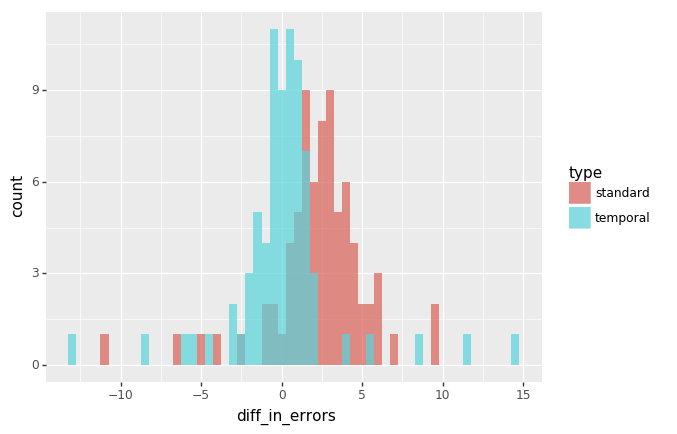

<ggplot: (-9223372036577881891)>

In [32]:
# Looking near 0 to remove some outliers
(ggplot(temp_vs_std, aes(x='diff_in_errors', fill='type')) +
    geom_histogram(binwidth=0.5, alpha=.7, position="identity")
)

From this plot, we can see that standard CV technique appears to predict higher errors than its selected model truly performed. 

It is also natural to ask about the absolute difference in the difference between the predicted and the actual errors for a given test year. That plot is below. Note that the temporal CV method has a lower absolute difference in predicted error and actual error.

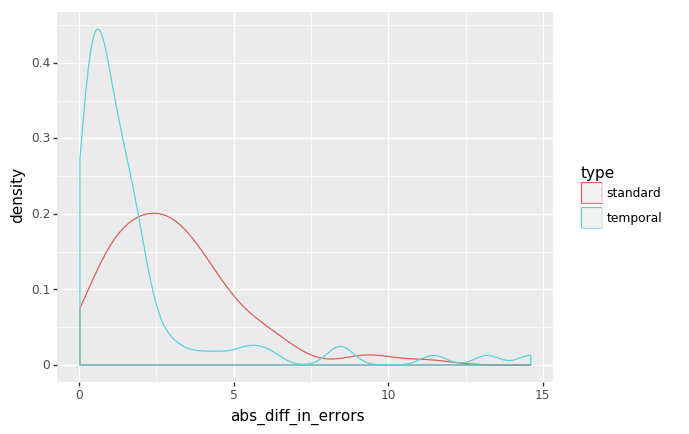

<ggplot: (-9223372036560105230)>

In [35]:
ggplot(temp_vs_std, aes(x="abs_diff_in_errors", colour='type')) + geom_density()

We can investigate how this difference in predicted vs actual error changes over the years tested. 

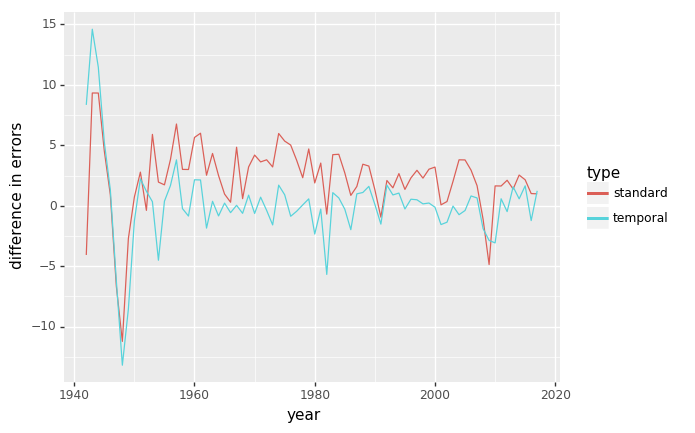

<ggplot: (294875442)>

In [36]:
(ggplot(temp_vs_std, aes(x='test_year', y='diff_in_errors', colour='type')) +
    geom_line() +
    xlab('year') +
    ylab('difference in errors')
)

Temporal CV, mostly because of the rolling window that was employed, tends to have a fairly unbiased prediction of its error for every year. 

### Error By Year, By Model

Below is a plot of the validation errors for each model for each year, coming from the temporal CV results. Ie, for each year, the plot shows the error for each model trained on all the prior years. 

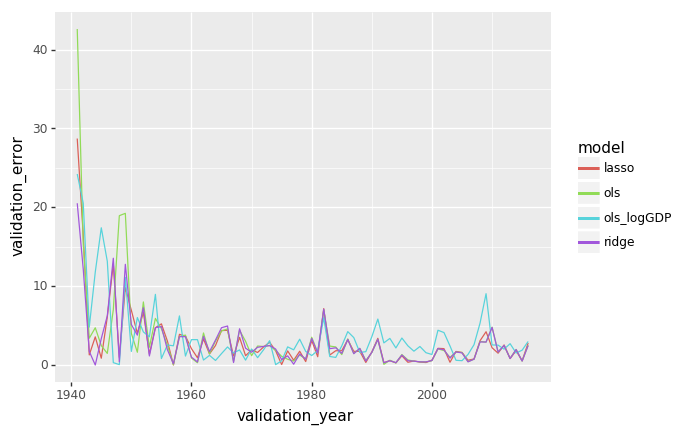

<ggplot: (294675951)>

In [37]:
(ggplot(temporal_results_df, aes(x="validation_year")) +
    geom_line(aes(y="validation_error", color="model"))
)

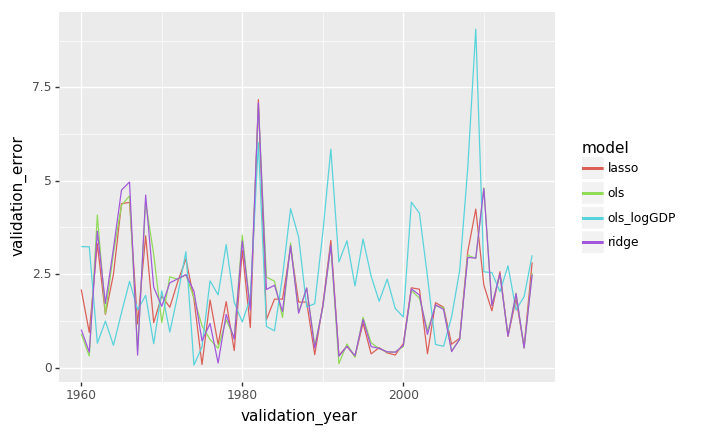

<ggplot: (294881372)>

In [38]:
# For 1960 and after to remove the large spikes at the beginning
(ggplot(temporal_results_df[temporal_results_df.cv_end > 1959], aes(x="validation_year")) +
    geom_line(aes(y="validation_error", color="model"))
)

From these we can see that there was not one model that consistently performed the best. In fact, they all show remarkable similarity in their percentage error for each year, except for the prediction of the log transformed values.

### How Often Did Each Method Chose The Best Model?

For each year, each model ranks a given place on its performance. Ie, in 1952 perhaps OLS had the lowest error (rank 1) and so on. The question is, how often did each CV method choose each rank?

In [39]:
for_ranking = temporal_results_df.pivot(index='validation_year', columns='model', values='validation_error')
rank = for_ranking.rank(axis=1)

In [40]:
ranks = []
for i, row in temp_vs_std.iterrows():
    year = row["test_year"]
    model = row["model"]
    
    if year != test_end_year:
        ranks.append(rank.at[year, model])
ranks += (None, None) # For temporal and standard in the final test year

temp_vs_std["ranks_of_models"] = ranks
temp_vs_std.head()

,mean_validation_error,model,test_error,test_year,type,diff_in_errors,abs_diff_in_errors,ranks_of_models
0,12.366571,lasso,16.441791,1942,standard,-4.075220,4.075220,3.0
1,20.524031,ridge,12.179753,1942,temporal,8.344277,8.344277,1.0
5,16.351892,ridge,1.744894,1943,temporal,14.606998,14.606998,2.0
7,11.074313,ridge,1.744894,1943,standard,9.329419,9.329419,2.0
11,9.344677,ridge,0.018746,1944,standard,9.325931,9.325931,1.0


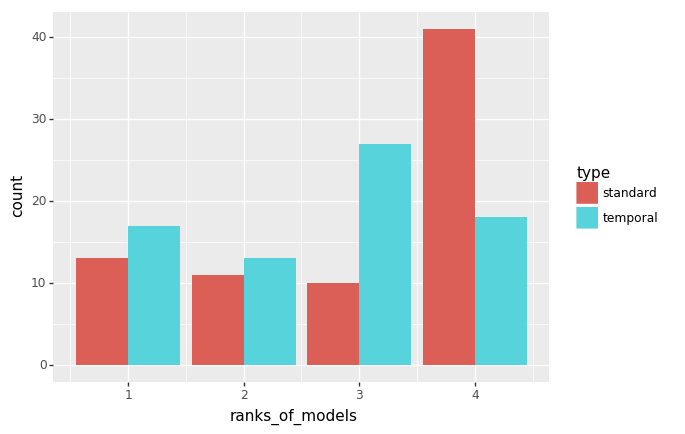

<ggplot: (-9223372036559751045)>

In [41]:
(ggplot(temp_vs_std[temp_vs_std.test_year != test_end_year], aes(x="ranks_of_models"))
    + geom_bar(aes(fill = "type"), position = "dodge")
)

In [42]:
temp_vs_std.groupby(["type"])["ranks_of_models"].mean()

type
standard    3.053333
temporal    2.613333
Name: ranks_of_models, dtype: float64

From these we can see that temporal tended to pick models that ended up ranking worse in subsequent years for this task.

### Model Regret
Beyond simply the rank of the models chosen, it is also informative to look at model regret: the difference in the actual performance for the model that was predicted to be the best performing vs the model that actual performed the best in the subsequent year. 

In [46]:
for_ranking.head()

model,lasso,ols,ols_logGDP,ridge
validation_year,,,,
1941,28.724943,42.607683,24.227677,20.524031
1942,16.441791,15.367902,20.523821,12.179753
1943,1.298195,3.416001,4.820817,1.744894
1944,3.588031,4.740666,11.802095,0.018746
1945,0.879214,2.477509,17.413047,3.364495


In [44]:
temp_vs_std = temp_vs_std.merge(for_ranking.min(axis=1).to_frame().reset_index(), \
                                    left_on='test_year', right_on='validation_year')
temp_vs_std.rename({0:'best_error'}, inplace=True, axis='columns')

In [49]:
temp_vs_std['regret'] = temp_vs_std['test_error'] - temp_vs_std['best_error']

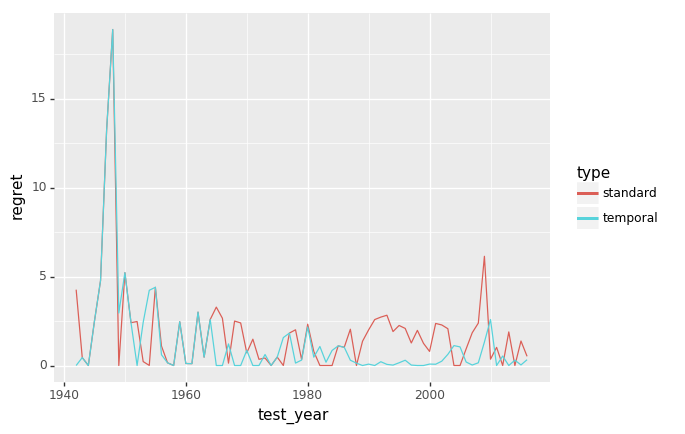

<ggplot: (-9223372036559661105)>

In [50]:
(
ggplot(temp_vs_std, aes(x="test_year")) + geom_line(aes(y = 'regret', color = 'type'))
)

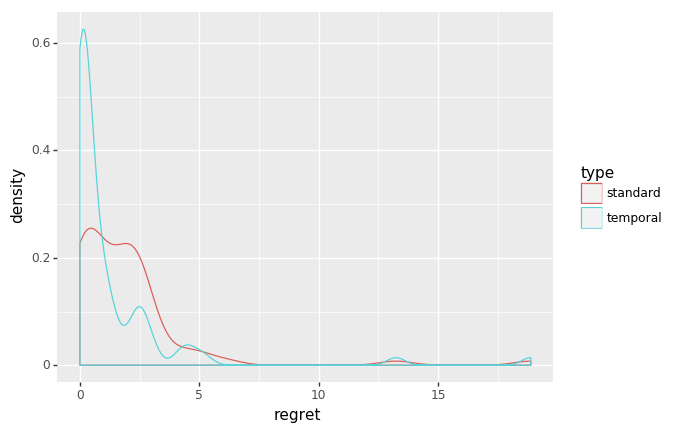

<ggplot: (295489726)>

In [51]:
(
ggplot(temp_vs_std, aes(x='regret', color='type')) + geom_density()
)

By this metric we can also see that temporal CV has selected models that have been closer to the truly best model for ever year, of the models tested.

# Classification Example: North Carolina Prisoner Recidivism

Perhaps even more ubiquitous than regression is classification-style problems. Here too can using temporal cross validation make a difference in the success of creating a model. 

For this example we will use public information on prisoners of North Carolina Department of Corrections. Each individual is given a unique identifier which allows for analyzing recidivism. Using the raw data, we collected a series of variables which may be able to predict if a given individual will recidivate within three years of their release date. The variables include: age at release, gender, race, most current conviction, most serious past conviction, facility of admission, escape history, prior convictions history, and number of infractions. 

In [194]:
data = pd.read_pickle("data_cv/recid_data.pickle")

In [195]:
data.head(10)

,INMATE_DOC_NUMBER,SENTENCE_END,SENTENCE_START,TOTAL_SENTENCE_COUNT,TOTAL_DISCIPLINE_INFRACTIONS,ESCAPE_HISTORY_FLAG,PRIOR_INCARCERATIONS_FLAG,AGE_AT_RELEASE,RECITIVATED,MOST_SERIOUS_OFFENSE_CODE_ARMED ROBBERY,...,MOST_SERIOUS_OFFNSE_CURR_INCAR_VIOLATION CONT SUB PENAL INST,MOST_SERIOUS_OFFNSE_CURR_INCAR_VIOLATION DRUG LAWS,MOST_SERIOUS_OFFNSE_CURR_INCAR_VIOLATION PROTECTIVE ORDER,MOST_SERIOUS_OFFNSE_CURR_INCAR_WANTON INJ PER/PROP $200 & LS,MOST_SERIOUS_OFFNSE_CURR_INCAR_WANTON INJ PER/PROP GT $200,MOST_SERIOUS_OFFNSE_CURR_INCAR_WILL/WANT INJ REAL PROPERTY,MOST_SERIOUS_OFFNSE_CURR_INCAR_WORTHLESS CHECK,INMATE_IS_FELON/MISDEMEANANT_MISD.,WEEKS_SERVED,SENTENCE_END_YEAR
0,4,1984-07-11,1983-07-12,0,0,0,1,22,0,0,...,0,0,0,0,0,0,0,0,52,1984
1,6,1973-03-28,1973-01-30,0,0,0,1,21,1,0,...,0,0,0,0,0,0,0,1,8,1973
2,6,1975-08-18,1973-04-11,0,0,0,1,24,0,0,...,0,0,0,0,0,0,0,1,122,1975
3,8,1990-05-17,1990-04-09,0,0,0,1,26,0,0,...,0,0,0,0,0,0,0,0,5,1990
4,8,1994-01-26,1993-08-30,0,0,0,1,30,1,0,...,0,0,0,0,0,0,0,0,21,1994
5,8,1995-09-14,1995-01-02,0,0,0,1,31,0,0,...,0,0,0,0,0,0,0,0,36,1995
6,10,1977-03-17,1975-06-11,0,0,0,1,23,1,0,...,0,0,0,0,0,0,0,0,92,1977
7,10,1983-06-27,1975-06-11,0,0,0,1,30,0,0,...,0,0,0,0,0,0,0,0,419,1983
8,14,1976-07-06,1975-08-18,0,0,0,1,54,1,0,...,0,0,0,0,0,0,0,1,46,1976
9,14,1978-01-23,1977-06-17,0,0,0,1,56,0,0,...,0,0,0,0,0,0,0,1,31,1978


Now we will repeat much of the same process as the regression example. For our error metric, we will consider the precision at the top 50 of predicted cases. Specifically, after the prediction step, we will select those will the highest predicted probablity of being a true label then consider the precision of those.

### Setup

A significant number of releases begin in 1973 and go through 2016. So we will use 1974 though 2013 as our testing years. Additionally we will block the release dates by year for purposes of training and testing. Because our error metric is now a grouped metric, we need many cases in a given validation year to test the model, so our validation years will start at 1973 for both standard and cross validation.

In [196]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [197]:
X_cols = data.columns.difference(['RECITIVATED', 'COMMITMENT_PREFIX', 'COMMITTED_FIRST_NAME', 'COMMITTED_LAST_NAME', 'INMATE_DOC_NUMBER', 'SENTENCE_END', 'SENTENCE_START'])
y_cols = 'RECITIVATED'

clfs = {
    'rf1': RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=30, max_features='log2', min_samples_split=10),
    'rf2': RandomForestClassifier(n_estimators=700, n_jobs=-1, max_depth=20, max_features='log2', min_samples_split=10),
    'extra1': ExtraTreesClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth=50, max_features='log2'),
    'extra2': ExtraTreesClassifier(n_estimators=400, n_jobs=-1, criterion='gini', max_depth=30, max_features='log2'),
    'logistic1': LogisticRegression(penalty='l1', C=0.001),
    'logistic2': LogisticRegression(penalty='l2', C=0.001),
    'decision1': DecisionTreeClassifier(criterion='gini', max_depth=20, max_features='sqrt', min_samples_split=2),
    'decision2': DecisionTreeClassifier(criterion='gini', max_depth=50, max_features='sqrt', min_samples_split=2)
}

test_begin_year = 1975
test_end_year = 2013
test_years = range(test_begin_year, test_end_year+1)

validation_years = range(test_begin_year-1, test_end_year)

In [198]:
def precision_at_abs(labels, predictions_proba):
    cutoff_index = 100
    
    random.seed(15)
    predictions_proba_sorted, labels_sorted = zip(*sorted(
        zip(predictions_proba, labels),
        key=lambda pair: (pair[0], random.random()), reverse=True)
    )
    
    test_predictions_binary = [
        1 if x < cutoff_index else 0
        for x in range(len(predictions_proba_sorted))
    ]
    
    return metrics.precision_score(labels_sorted, test_predictions_binary)

### Standard Cross Validation

In [7]:
def standard_cv_classification(test_year, validation_year, model):
    
    if validation_year < test_year:
        
        try:
            cv_start = 1950
            cv_end = test_year - 1
        
            # prep validation data
            df_validation = data[data.SENTENCE_END_YEAR == validation_year]
            X_validation = df_validation[X_cols]
            y_validation = df_validation[y_cols]
        
            # prep training data
            df_standard_train = data[(data.SENTENCE_END_YEAR != validation_year) &\
                                     (data.SENTENCE_END_YEAR < test_year)]
            X_standard_train = df_standard_train[X_cols]
            y_standard_train = np.ravel(df_standard_train[y_cols])

            
            # fit the models
            clf = clfs[model]
            clf.fit(X_standard_train, y_standard_train)
            validation_precision = precision_at_abs(y_validation, clf.predict(X_validation))

            # return the results
            return(cv_start, cv_end, validation_year, model, validation_precision)
        
        except:
            pass

The above code is how we can generate the models and find their precisions. However, this is a very computationally demanding task, particularly for the latter years of the training set. Therefore we ran an optimized version in parallel on AWS. See `data_cv/get_cv_results.py` for the code. The results are stored in `data_cv/cv_results.csv`.

In [199]:
c_standard_cv_results_df = pd.read_csv('data_cv/cv_results.csv', \
                                       names=['cv_start', 'cv_end', 'validation_year', 'model', 'val_precision'])
c_standard_cv_results_df.sort_values(['cv_start', 'cv_end', 'validation_year', 'model'], inplace=True)
c_standard_cv_results_df = c_standard_cv_results_df[c_standard_cv_results_df.cv_end != 1973] # Data fully starts in 1973
c_standard_cv_results_df.head(15)

,cv_start,cv_end,validation_year,model,val_precision
88,1950,1974,1973,decision1,0.58
0,1950,1974,1973,decision2,0.43
83,1950,1974,1973,extra1,0.61
118,1950,1974,1973,extra2,0.79
78,1950,1974,1973,logistic1,0.56
94,1950,1974,1973,logistic2,0.81
38,1950,1974,1973,rf1,0.82
72,1950,1974,1973,rf2,0.83
153,1950,1974,1974,decision1,0.57
240,1950,1974,1974,decision2,0.44


Next we can repeat the methods used above to select our best model for each year and compare its estimated performance to its actual for the test year. Note two changes: 1) We now want the maximum precision, not the minimum error. 2) Training the model for our final year is now prohibitively expensive, so we will simply disregard that year.

In [200]:
# Grouping by the test year and the model type, what is the average cv_error?
c_grouped_standard_cv_results = c_standard_cv_results_df.groupby(['cv_end', 'model'])['val_precision'].mean().to_frame().reset_index()
c_grouped_standard_cv_results.rename(columns = {"val_precision": "mean_val_precision"}, inplace=True)

# Finding the models with the lowest average cv_error for each year
c_standard_cv_best_models = c_grouped_standard_cv_results.loc[c_grouped_standard_cv_results.groupby(['cv_end'])\
                                                         ['mean_val_precision'].idxmax()]

# Going from cv_end year to test year
c_standard_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
c_standard_cv_best_models["test_year"] = c_standard_cv_best_models["test_year"] + 1 

c_standard_cv_best_models = c_standard_cv_best_models[c_standard_cv_best_models.test_year != test_end_year]

test_precisions = []
for index, row in c_standard_cv_best_models.iterrows():
    test_yr = row["test_year"]
    model = row["model"]
    
    test_prec = c_standard_cv_results_df[(c_standard_cv_results_df.cv_end == test_yr) \
                                      & (c_standard_cv_results_df.validation_year == test_yr)
                                      & (c_standard_cv_results_df.model == model)].iloc[0]["val_precision"]
        
    test_precisions.append(test_prec)

c_standard_cv_best_models["test_precisions"] = test_precisions
c_standard_cv_best_models["type"] = "standard"

In [202]:
c_standard_cv_best_models.head(10)

,test_year,model,mean_val_precision,test_precisions,type
5,1975,logistic2,0.800000,0.76,standard
12,1976,logistic1,0.760000,0.82,standard
20,1977,logistic1,0.812500,0.81,standard
28,1978,logistic1,0.804000,0.84,standard
36,1979,logistic1,0.795000,0.74,standard
44,1980,logistic1,0.771429,0.75,standard
51,1981,extra2,0.751250,0.79,standard
63,1982,rf2,0.748889,0.79,standard
67,1983,extra2,0.749000,0.75,standard
75,1984,extra2,0.750909,0.64,standard


## Temporal Cross Validation

Note that, as discussed before, all of the folds that would be be trained in temporal CV are also trained in standard, so we can select our `c_temporal_results_df` as a subset of the `c_standard_cv_results_df`. This is also why temporal CV is much more efficient. In cases like this, that translates to lower computation costs or the ability to audition more models.

In [203]:
c_temporal_results_df = c_standard_cv_results_df[c_standard_cv_results_df.validation_year == \
                                                 c_standard_cv_results_df.cv_end]

In [204]:
c_temporal_results_df.tail(16)

,cv_start,cv_end,validation_year,model,val_precision
6256,1950,2011,2011,decision1,0.69
6404,1950,2011,2011,decision2,0.63
6223,1950,2011,2011,extra1,0.71
6367,1950,2011,2011,extra2,0.73
6466,1950,2011,2011,logistic1,0.65
6321,1950,2011,2011,logistic2,0.55
6152,1950,2011,2011,rf1,0.77
6444,1950,2011,2011,rf2,0.86
6490,1950,2012,2012,decision1,0.63
6534,1950,2012,2012,decision2,0.56


When using temporal CV, we often use a rolling average for estimating the precision of models. Ie, instead of simply averaging the precision of all prior years to estimate what our precision will be in the future, we will only average the years going back a set number. This allows the algorithm to be more agile if the model performance begins to change.

In [205]:
rolling_avg_num_years = 5

rows_list = []
for validation_yr in validation_years:
    for model in clfs:
        row_dict = {}
        row_dict["model"] = model
        row_dict["cv_end"] = validation_yr
        row_dict["mean_val_precision"] = c_temporal_results_df[\
                  (c_temporal_results_df.validation_year <= validation_yr) \
                & (c_temporal_results_df.validation_year >= validation_yr - rolling_avg_num_years) \
                & (c_temporal_results_df.model == model)]["val_precision"].mean()
        rows_list.append(row_dict)
        
c_grouped_temporal_cv_results = pd.DataFrame(rows_list)

# Finding the models with the lowest average cv_error for each year
c_temporal_cv_best_models = c_grouped_temporal_cv_results.loc[c_grouped_temporal_cv_results.groupby(['cv_end'])\
                                                             ['mean_val_precision'].idxmax()]

# Going from cv_end year to test year
c_temporal_cv_best_models.rename(columns={"cv_end":"test_year"}, inplace=True)
c_temporal_cv_best_models["test_year"] = c_temporal_cv_best_models["test_year"] + 1

c_temporal_cv_best_models = c_temporal_cv_best_models[c_temporal_cv_best_models.test_year != test_end_year]


test_precisions = []
for index, row in c_temporal_cv_best_models.iterrows():
    test_yr = row["test_year"]
    model = row["model"]
    
    test_prec = c_temporal_results_df[(c_temporal_results_df.validation_year == test_yr)
                                     & (c_temporal_results_df.model == model)].iloc[0]["val_precision"]
        
    test_precisions.append(test_prec)

c_temporal_cv_best_models["test_precisions"] = test_precisions

c_temporal_cv_best_models["type"] = "temporal"

In [206]:
c_temporal_cv_best_models.head(10)

,test_year,mean_val_precision,model,test_precisions,type
5,1975,0.790000,logistic2,0.76,temporal
13,1976,0.775000,logistic2,0.68,temporal
21,1977,0.743333,logistic2,0.70,temporal
29,1978,0.732500,logistic2,0.75,temporal
36,1979,0.738000,logistic1,0.74,temporal
44,1980,0.738333,logistic1,0.75,temporal
52,1981,0.795000,logistic1,0.76,temporal
60,1982,0.786667,logistic1,0.73,temporal
68,1983,0.771667,logistic1,0.67,temporal
75,1984,0.766667,extra2,0.64,temporal


### Results Comparison

In [207]:
c_temp_vs_std = pd.concat([c_standard_cv_best_models, c_temporal_cv_best_models]).sort_values(by="test_year")
c_temp_vs_std["diff_in_prec"] = c_temp_vs_std["mean_val_precision"] - c_temp_vs_std["test_precisions"]
c_temp_vs_std["abs_diff_in_prec"] = abs(c_temp_vs_std["mean_val_precision"] - c_temp_vs_std["test_precisions"])
c_temp_vs_std.head(6)

,mean_val_precision,model,test_precisions,test_year,type,diff_in_prec,abs_diff_in_prec
5,0.800000,logistic2,0.76,1975,standard,0.040000,0.040000
5,0.790000,logistic2,0.76,1975,temporal,0.030000,0.030000
12,0.760000,logistic1,0.82,1976,standard,-0.060000,0.060000
13,0.775000,logistic2,0.68,1976,temporal,0.095000,0.095000
20,0.812500,logistic1,0.81,1977,standard,0.002500,0.002500
21,0.743333,logistic2,0.70,1977,temporal,0.043333,0.043333


Let us repeat the post modeling analyses that we conducted for the regression task, beginning with the distribution of the differences in the predicted precision and the actual precisions for the selected model by both methods of CV.

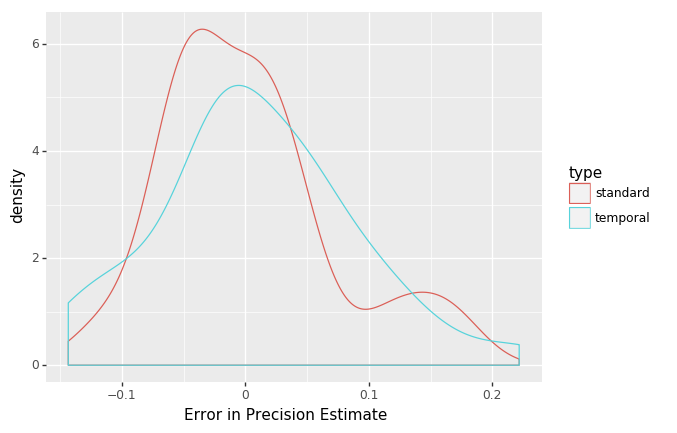

<ggplot: (-9223372036560710470)>

In [208]:
ggplot(c_temp_vs_std, aes(x="diff_in_prec", colour='type')) + geom_density() + xlab("Error in Precision Estimate")

These results indicate that, for this classification task, standard CV does appear to have a slightly biased prediction of precision. Specifically, it appears to be predicting precisions slightly lower than the actual precision for a given year. On the other hand, the predictions of temporal CV are more closely centered around 0 than those of temporal CV, but spread slightly wider.

Next, lets evaluate how the difference in predicted precision and actual precision varied over the years for both CV strategies.

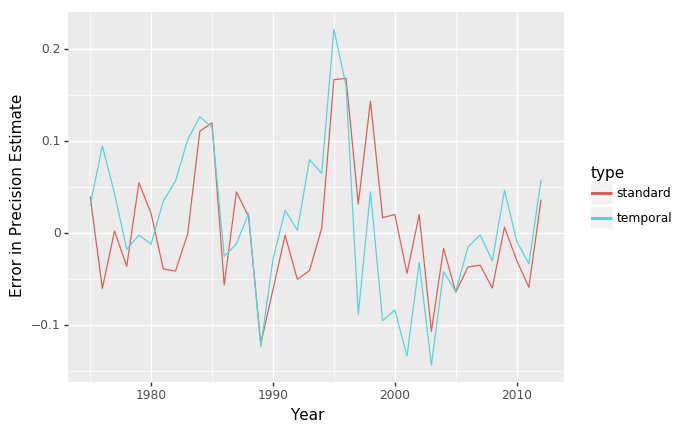

<ggplot: (294313662)>

In [209]:
(ggplot(c_temp_vs_std, aes(x='test_year', y='diff_in_prec', colour='type')) +
    geom_line() +
    xlab('Year') +
    ylab('Error in Precision Estimate')
)

This shows us that both methods had fairly unbiased estimates for precision before 2000, at which point both began to predict lower precision than was actually achieved. However, temporal's predictions were generally lower. This is likely because both CV strategies started selecting the model `rf2`, which may have had worse performace in early years and better in later years (recall that the predicted precision for a given year is the average of the precision for all folds prior).

We can evaluated this hypothesis by looking at the performance of the models across years (4 models at a time).

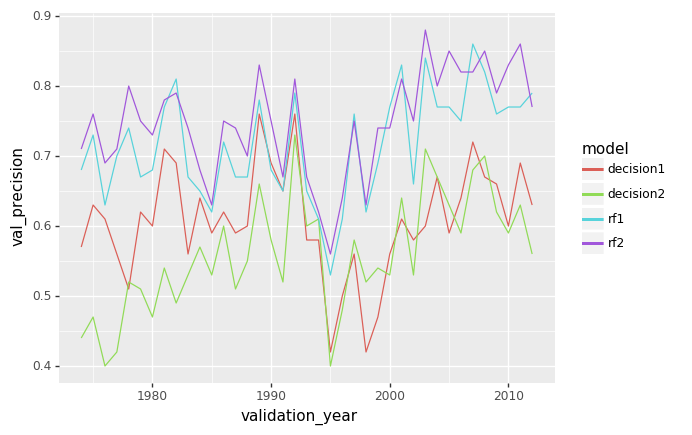

<ggplot: (294016730)>

In [210]:
set1 = ['decision1', 'decision2', 'rf1', 'rf2']
set2 = ['extra1', 'extra2', 'logistic1', 'logistic2']

(ggplot(c_temporal_results_df[c_temporal_results_df.model.isin(set1)], aes(x="validation_year")) +
    geom_line(aes(y="val_precision", color="model"))
)

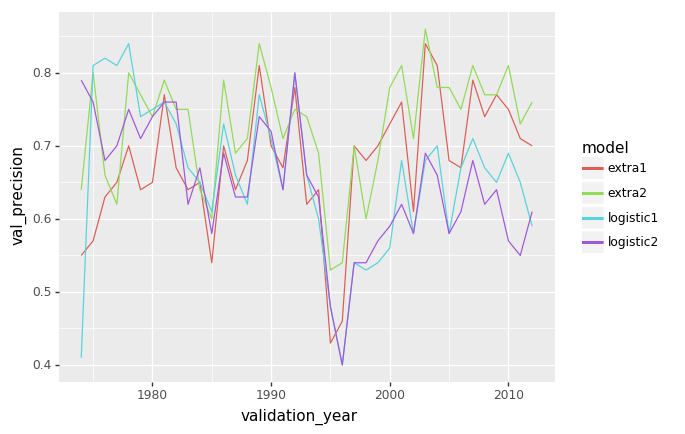

<ggplot: (-9223372036561908059)>

In [211]:
(ggplot(c_temporal_results_df[c_temporal_results_df.model.isin(set2)], aes(x="validation_year")) +
    geom_line(aes(y="val_precision", color="model"))
)

From these plots, we can see that model `rf2` does indeed have a large improvement in precision after 2000. But even more significant is the large drop in precision of all models in 1995. This sudden change is what is responsible for the poor precision predictions in the years after 1995 by the temporal CV. See the graph below.

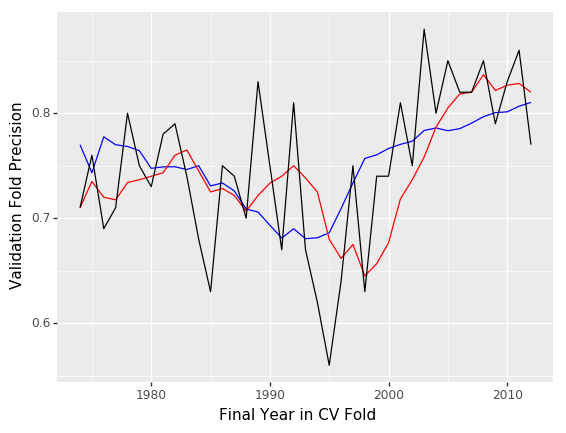

<ggplot: (-9223372036560526304)>

In [212]:
(
ggplot() + 
  geom_line(c_grouped_standard_cv_results[c_grouped_standard_cv_results.model == 'rf2'], aes(x="cv_end", y='mean_val_precision'), color = "blue") +
  geom_line(c_grouped_temporal_cv_results[c_grouped_temporal_cv_results.model == 'rf2'], aes(x="cv_end", y='mean_val_precision'), color = "red") +
  geom_line(c_temporal_results_df[c_temporal_results_df.model == 'rf2'], aes(x="cv_end", y='val_precision'), color = "black") +
  xlab('Final Year in CV Fold') +
  ylab('Validation Fold Precision')
)

Here the X-axis is the same as `test_year - 1`. The red line is the precision estimated by temporal CV, the blue line is the precision estimated by standard CV. The black is the actual performace.

### Investigating the dip in precision in 1995

In [213]:
# Finding the recidivism percentage and number of released prisioners by year.
recid_stats = data.groupby('SENTENCE_END_YEAR').agg({'RECITIVATED': ['mean','count']}).reset_index()
recid_stats.columns = ['SENTENCE_END_YEAR', 'RECID_PERCENT', 'RELEASED_COUNT']
recid_stats = recid_stats[recid_stats.SENTENCE_END_YEAR.between(test_begin_year, test_end_year)]

In [214]:
# Finding the number of prisoners inducted per year
data["SENTENCE_START_YEAR"] = data.SENTENCE_START.dt.year
entry_stats = data.groupby('SENTENCE_START_YEAR').agg({'RECITIVATED': ['count']}).reset_index()
entry_stats.columns = ['SENTENCE_START_YEAR', 'INDUCTED_COUNT']


stats = recid_stats.merge(entry_stats, left_on='SENTENCE_END_YEAR', right_on='SENTENCE_START_YEAR')
stats["Net"] = stats["INDUCTED_COUNT"] - stats["RELEASED_COUNT"]
stats['Total'] = stats.Net.rolling(50, min_periods=1).sum()

melted = pd.melt(stats, id_vars=['SENTENCE_END_YEAR'], value_vars=['RELEASED_COUNT', 'INDUCTED_COUNT', "Total"])

First, we should look at the recidivism percentages for each year to see if there was a significant change around 1995. In the same graph we will plot the precisions of the models selected by both CV strategies.

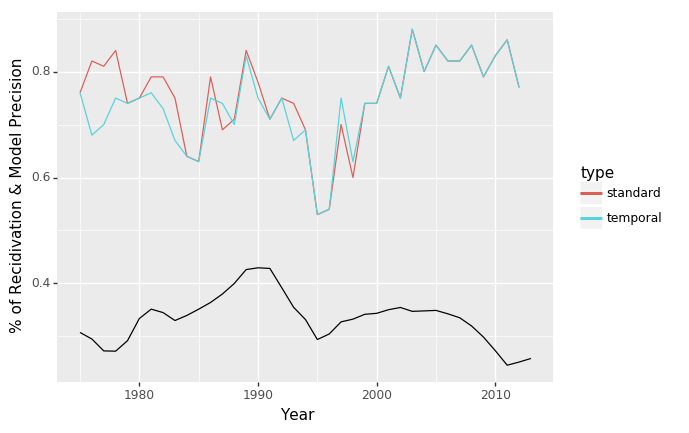

<ggplot: (-9223372036577798908)>

In [215]:
warnings.filterwarnings(action="ignore", module="mizani", message="^overflow")

(ggplot() + 
 geom_line(c_temp_vs_std, aes(x="test_year", y="test_precisions", color="type")) +
 geom_line(stats, aes(x='SENTENCE_END_YEAR', y = 'RECID_PERCENT')) + 
 xlab('Year') + ylab("% of Recidivation & Model Precision")
)

We should think of the % of recidivism as a baseline precision per year for our models. Ie, if our model predicted 100 random prisioners as likely to recidivate, the precision we'd expect would be the percentage who ended up recidivating for that year.

From this we can indeed see that, around the mid 1990's, the percentage of prisoners recitivating declined sharply. So models trained on the years prior and tested on these years should be expected to underperform.

To continue examining the cause for the poor predictability of recidivism in the mid 1990s, let us look at the next flux of prisoners by year.

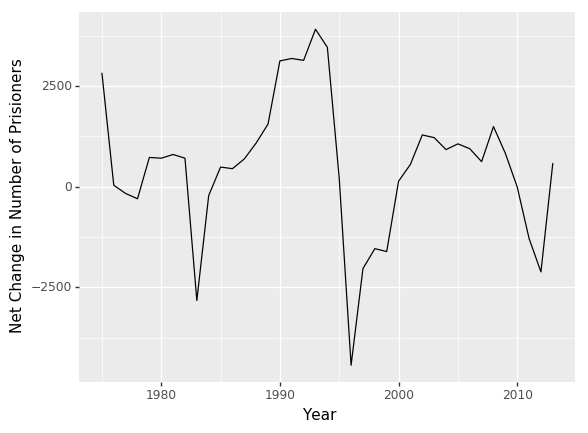

<ggplot: (-9223372036560758447)>

In [216]:
(ggplot() + geom_line(stats, aes(x='SENTENCE_END_YEAR', y = 'Net'))
 + xlab('Year') + ylab("Net Change in Number of Prisioners")
)

For every year, this plot shows the number of prisoners inducted - number released. The change around 1995 in this graph is even more drastic. From 1994 to 1996, the prison went from a net influx of 3459 individuals to a net efflux of 4432.

Finally, we can examine the the number of prisoners whose sentences began and ended by year, as well as the prison population change over time.

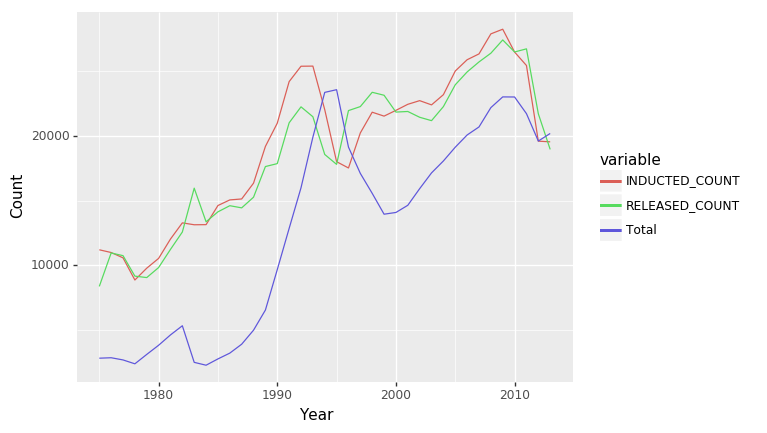

<ggplot: (296865663)>

In [32]:
(ggplot(melted, aes(x="SENTENCE_END_YEAR")) +
  geom_line(aes(y = 'value', color='variable')) +
  xlab('Year') + ylab('Count')
)

The blue line above represents the compounding net flux of inmates from each year. In other words, what the total population would be if the population started at 0 in the first year, (not the true total population because the dataset does not contain the initial population count)

From these two plots, we can gather that there is evidence for a widescale change in North Carolina's criminal justice system that resulted in changes the population flux and recidivism rates. 

### How often did each method select the best model?

Below is a histogram of the ranks of the models selected by each method. Eg, if standard CV selected `extra1` to use in 1982, and that model ended up being the second best that year, it would increase the count under 2.

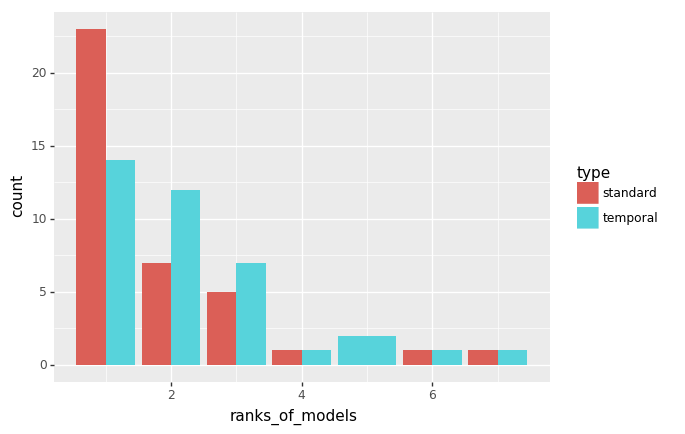

<ggplot: (297365915)>

In [35]:
c_for_ranking = c_temporal_results_df.pivot(index='validation_year', columns='model', values='val_precision')
c_rank = c_for_ranking.rank(axis=1, ascending=False, method='min')

ranks = []
for i, row in c_temp_vs_std.iterrows():
    year = row["test_year"]
    model = row["model"]
    
    if year != test_end_year:
        ranks.append(c_rank.at[year, model])

c_temp_vs_std["ranks_of_models"] = ranks

(ggplot(c_temp_vs_std[c_temp_vs_std.test_year != test_end_year], aes(x="ranks_of_models"))
    + geom_bar(aes(fill = "type"), position = "dodge")
)

In [147]:
# The average rank of the model selected
c_temp_vs_std.groupby(["type"])["ranks_of_models"].mean()

type
standard    1.815789
temporal    2.263158
Name: ranks_of_models, dtype: float64

We can see that, in this respect, standard CV did often select a higher ranked model than temporal. Arguably more important is model regret.

### Model Regret

Model regret is the difference between the actual precision for a selected model and the actual performance of the best model per year. In other words, if a given algorithm did not select the best model, what was the difference between the selected model's precision and the best model's precision.

In [82]:
c_temp_vs_std = c_temp_vs_std.merge(for_ranking.max(axis=1).to_frame().reset_index(), \
                                    left_on='test_year', right_on='validation_year')

In [83]:
c_temp_vs_std.rename({0:'best_precision'}, inplace=True, axis='columns')

In [87]:
c_temp_vs_std['regret'] = c_temp_vs_std['best_precision'] - c_temp_vs_std['test_precisions']

Here is the regret by year, followed by the regret density.

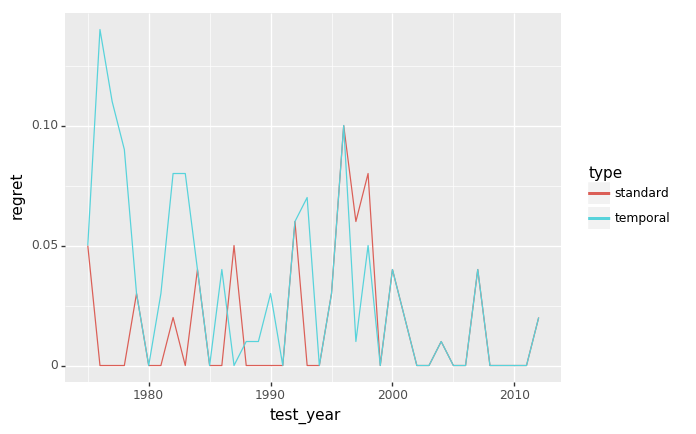

<ggplot: (-9223372036556999694)>

In [89]:
(
ggplot(c_temp_vs_std, aes(x="test_year")) + geom_line(aes(y = 'regret', color = 'type'))
)

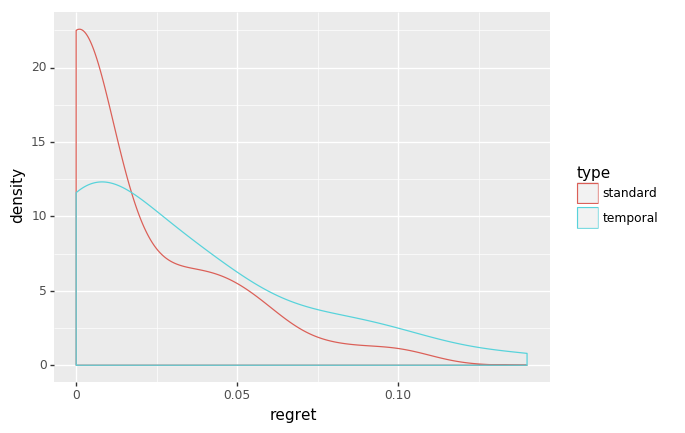

<ggplot: (-9223372036556999883)>

In [90]:
(
ggplot(c_temp_vs_std, aes(x='regret', color='type')) + geom_density()
)

In [93]:
# The mean regret by method
c_temp_vs_std.groupby(["type"])["regret"].mean()

type
standard    0.017105
temporal    0.031316
Name: regret, dtype: float64

We can see that, for this task, unlike the regression task, temporal CV had a larger average regret. 

## Post Analysis of Classification Results

Throughout this notebook, we have argued for usage of temporal CV in time series data. This real world classification example demonstrates some of the reasons as to why. First is the question of computational power. In this example we modeled 38 years of prisoner recidivism, a dataset containing about 800,000 rows and 500 columns. Standard CV required the training of 6552 models, which lasted around 8 hours of training time on a 128 core machine on AWS. Temporal CV required only 312 models, which means with roughly the same computational time we could have tested 168 models instead of 8. And as we can see with all of the analyses above, temporal CV generally results in similar precisions and decisions as temporal CV. 

Further, there are specific situations in which standard CV can result in biased predictions. Consider the case of a sudden change in the underlying pattern that we are trying to model, as we saw around 1995. At the test year of 1995, neither CV system knows that the change is coming, as therefore the models that they select should to perform poorly when trained on all the years prior and tested on 1995. But the subsequent years will differ. 

Consider what occurs in the test year 1998. To estimate the performance of a given model in that year, standard CV will include a fold that trains all of the models on all the years between 1950 and 1987 except 1995 and then test on 1995. This model will essentially know that the change is coming and have a precision that is higher than the model would have performed in 1995. This influence can be slight, but nonetheless introduces a source of bias in the predictions of what our precision will likely be. 

Of course, in practice, this bias can be overshadowed by the variance of the models and selection algorithms themselves. In this task, for example, the standard CV algorithm actually predicted precisions that tended to be somewhat lower than the actual precisions (see the first graph in 'Results Comparison').

We can hone in on the decade surrounding the 1995 change to see this difference in practice.

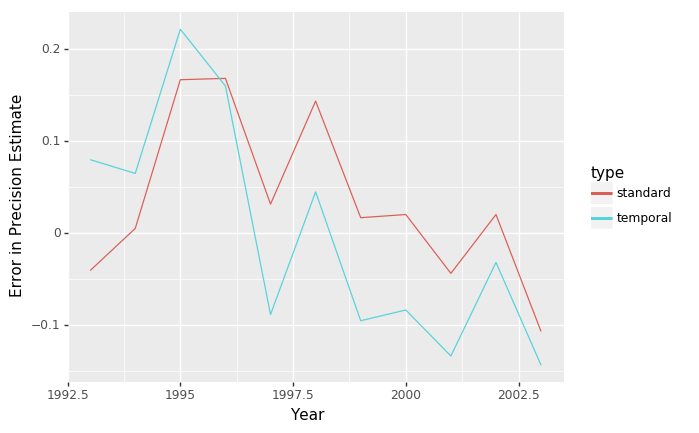

<ggplot: (-9223372036561099320)>

In [217]:
(ggplot(c_temp_vs_std[(c_temp_vs_std.test_year >=1993) & (c_temp_vs_std.test_year <= 2003)], aes(x='test_year', y='diff_in_prec', colour='type')) +
    geom_line() +
    xlab('Year') +
    ylab('Error in Precision Estimate')
)

In [218]:
# The mean difference in predicted and actual precisions for the years visualized above.
c_temp_vs_std[(c_temp_vs_std.test_year >=1993) & (c_temp_vs_std.test_year <= 2003)].groupby(["type"])["diff_in_prec"].mean()

type
standard    0.034771
temporal   -0.000303
Name: diff_in_prec, dtype: float64

Given that this problem is from real-world data, the trend observed in the years above is impossible to attribute directly to the error estimating methods of standard CV, given the variance in the performance of the models and the underlying data. But the motivating factor remains, that in cases of changes in trends on underlying data, standard cross validation will introduce error in its predictions of the out-of-sample performance of the models being tested. 

For that reason and for the issue of computational savings, mixed with the demonstrably similar (or better) performance of this cross validation technique for regression and classification problems, we at DSaPP prefer using temporal cross validation whenever attempting to model timeseries data. 